
Testing for N = 2
Solution: [0 0]
Peak Memory Used: 1.61 MB
Time Taken: 9.666593 seconds

Testing for N = 4
Solution: [0 1 0 0]
Peak Memory Used: 0.20 MB
Time Taken: 18.753884 seconds

Testing for N = 6
Solution: [0 0 0 0 0 1]
Peak Memory Used: 0.22 MB
Time Taken: 22.677355 seconds

Testing for N = 8
Solution: [0 0 0 0 0 0 0 0]
Peak Memory Used: 0.22 MB
Time Taken: 30.519382 seconds

Testing for N = 10
Solution: [0 1 0 0 0 0 0 0 1 1]
Peak Memory Used: 0.22 MB
Time Taken: 42.089483 seconds


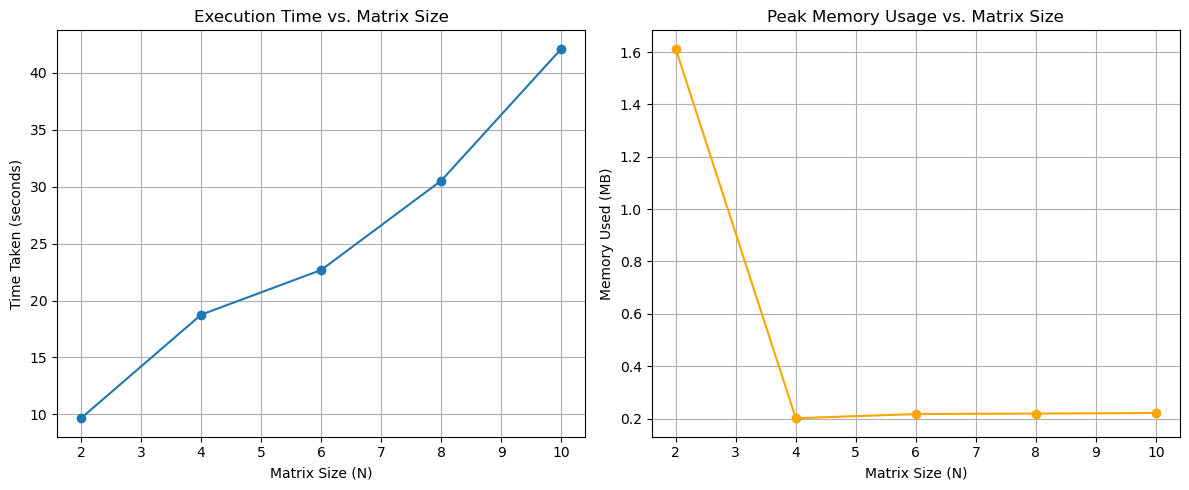

In [4]:
import dimod
from dimod import SimulatedAnnealingSampler
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt

def qubosolver(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()

    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to MB
    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

def test_scalability():
    Ns = []
    times = []
    memories = []
    max_N = 200000  # Adjust this value based on your system's capacity
    step = 20    # Increment size for N
    density = 0.05  # Density of the sparse matrix

    for N in range(20, max_N + 1, step):
        print(f"\nTesting for N = {N}")
        try:
            # Generate a random sparse binary matrix A
            A = sparse_random(N, N, density=density, format='csc', data_rvs=np.ones).astype(int)

            # Ensure symmetry if required (assuming A should be symmetric)
            A = A + A.T
            A.data[:] = 1  # Ensure all non-zero entries are 1

            # Generate a random binary vector b
            b = np.random.randint(0, 2, size=N)

            # Run the qubosolver
            _, memory_used, time_taken = qubosolver(A, b)

            # Record the results
            Ns.append(N)
            times.append(time_taken)
            memories.append(memory_used)

        except MemoryError:
            print("MemoryError encountered. Stopping the test.")
            break
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Plot for Execution Time
    plt.subplot(1, 2, 1)
    plt.plot(Ns, times, marker='o')
    plt.title('Execution Time vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time Taken (seconds)')
    plt.grid(True)

    # Plot for Memory Usage
    plt.subplot(1, 2, 2)
    plt.plot(Ns, memories, marker='o', color='orange')
    plt.title('Peak Memory Usage vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Memory Used (MB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the scalability test
test_scalability()




Testing for N = 20
Solution: [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]
Peak Memory Used: 91.51 MB
Time Taken: 9.521738 seconds

Testing for N = 40
Solution: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1
 0 0 0]
Peak Memory Used: 52.39 MB
Time Taken: 8.398029 seconds

Testing for N = 60
Solution: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0]
Peak Memory Used: 52.55 MB
Time Taken: 8.905335 seconds

Testing for N = 80
Solution: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0]
Peak Memory Used: 52.98 MB
Time Taken: 14.017142 seconds

Testing for N = 100
Solution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Peak Mem

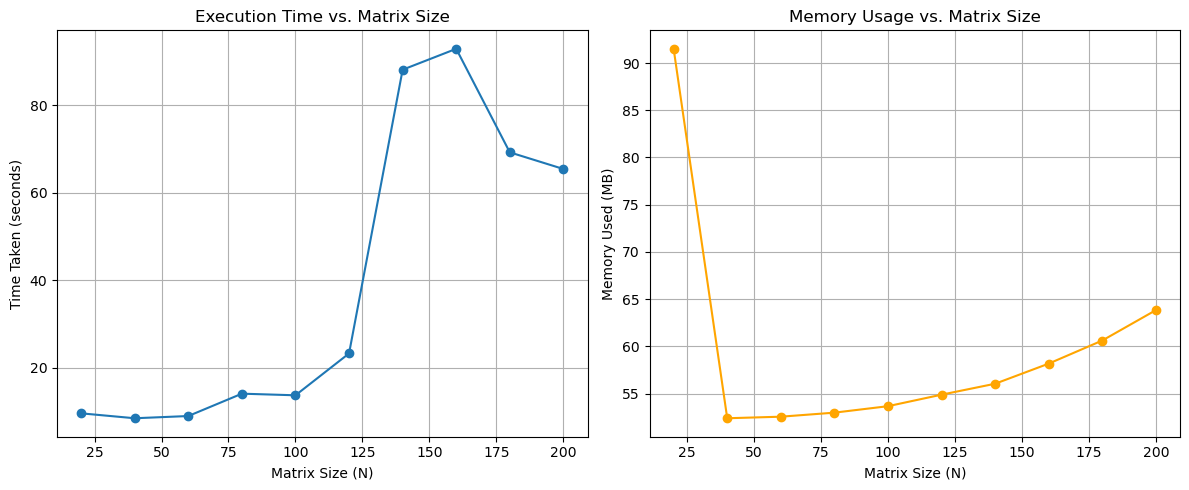

In [3]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt

def qubosolver(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-2df6769d96a5ddaec4b4e037d3a7a92833582e9c'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to MB
    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

def test_scalability():
    Ns = []
    times = []
    memories = []
    max_N = 3000   # Adjusted based on D-Wave hardware limitations
    step = 20   # Increment size for N
    density = 0.05  # Density of the sparse matrix

    for N in range(20, max_N + 1, step):
        print(f"\nTesting for N = {N}")
        try:
            # Generate a random sparse binary matrix A
            A = sparse_random(N, N, density=density, format='csc', data_rvs=np.ones).astype(int)

            # Ensure symmetry if required (assuming A should be symmetric)
            A = A + A.T
            A.data[:] = 1  # Ensure all non-zero entries are 1

            # Generate a random binary vector b
            b = np.random.randint(0, 2, size=N)

            # Run the qubosolver
            _, memory_used, time_taken = qubosolver(A, b)

            # Record the results
            Ns.append(N)
            times.append(time_taken)
            memories.append(memory_used)

        except Exception as e:
            print(f"An error occurred: {e}")
            break

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Plot for Execution Time
    plt.subplot(1, 2, 1)
    plt.plot(Ns, times, marker='o')
    plt.title('Execution Time vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time Taken (seconds)')
    plt.grid(True)

    # Plot for Memory Usage
    plt.subplot(1, 2, 2)
    plt.plot(Ns, memories, marker='o', color='orange')
    plt.title('Memory Usage vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Memory Used (MB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the scalability test
test_scalability()
